**Names**: Tia (2205775), Bram Schork (2205684), Jacob Alderete (2206035)

# Imports

In [19]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import warnings

# We'll suppress some warnings from tensorflow, but feel free to
# comment out this line and see some of the efficiency gains we can get!
warnings.filterwarnings("ignore")

# SEED = 72 our seed
SEED = 519

# Introduction

In this problem set you will fit a simple feed-forward Neural Net in order to demonstrate how a neural net can be used to identify dependencies across factors in order to create a higher alpha.

In question 1, we'll explore the comparison of a neural net to a linear model fit, and demonstrate some of the reasoning why a ReLU activation function is a common choice for neural nets in finance. In question 2, we'll analyze whether lag parameters may help further increase the performance of our model. In question 3, we'll investigate the importance of checking and robustness and reproducibility of the results of our fit.

I have included some sample output as a sanity check for some questions. As discussed in question 3, the optimization of the neural net uses a stochastic component, and thus, your estimates will be slightly different from when you see here.

# Starting Code

You'll be asked to update the following starting code in order to update the model being fit. This will include model parameters, as well as updating the input space.

The `fitting_returns_data` function is the main function that we'll run in order to pull results.

The functions with an `io_` prefix define input and output variables. The functions with a `'model_` prefix define the model fit that we'll be using.

This problem set will ask you to create your own `io_` and `model_` functions in order to test different modeling possibilities, and to determine the importance of these decisions in the model fitting process.

In [24]:
# Note: All io_fns and model_fns start with an 'io_' and 'model_' prefix
# respectively

def fitting_returns_data(data_path,
                         io_fn,
                         model_fn,
                         seed = None,
                         print_summary = True):
    """
    Fits data to supplied model and provides returns and alpha estimates.

        Parameters:
            data_path (str): path to factor data with first column as date
                6 factors, and the last column as risk free rate
            io_fn (fn): a function to calculate input/output pairs for the
                model fit
            model_fn (fn): a function that takes in input data, output data,
                and training and testing values, and returns the strategy
                for each day, and the observed return for each day
            seed (int): if given, the seed for the model fit will be set to
                this value
            print_summary (bool): if True, then the model won't print a summary
                of the OLS fit for our strategy return.
        Returns:
            strat_df (pd.DataFrame): The weights we would give each factor
                on each day
            return_vector (list): The returns from our strategy on each day
            model_OLS (RegressionResultsWrapper): A regression calculating the
                alpha for our strategy
    """
    # if given, set the random seed
    if seed:
        set_seed(seed)

    # Load the data into a pandas DataFrame
    data = pd.read_csv(data_path)
    # Drop date and risk free rate
    data = data.iloc[:, 1:7]

    # Shift the data by one time step to create input/output pairs
    X, y = io_fn(data)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # Fit the model
    strat_df, return_vector = model_fn(X, y, X_train, y_train, X_val, y_val)

    # Calculate alpha
    y_ols = sm.add_constant(y)
    model_OLS = sm.OLS(return_vector, y_ols).fit()
    if print_summary:
        print(model_OLS.summary())

    return strat_df, return_vector, model_OLS

def set_seed(seed_value):
    # Adding a fixed seed from this solution: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.compat.v1.set_random_seed(seed_value)
    return

def io_day_1_lag(data):
    # Create input output pairs, where the input is the previous day of data
    # and the output is the current day of data.
    X = data.shift(1).dropna().reset_index(drop=True)
    y = data.dropna().iloc[1:,:].reset_index(drop=True)
    return X, y

def io_day_1_lag_second_order_input(data):
    # Create input output pairs where input data includes second order interactions
    X, y = io_day_1_lag(data)
    cols = X.columns

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col_name = cols[i] + cols[j]
            col_values = X[cols[i]] * X[cols[j]]
            X[col_name] = col_values
    return X, y

def model_feed_forward(X, y, X_train, y_train, X_val, y_val):
    # Define the neural network model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model, verbose = 0 means reports aren't printed
    # at the end of each epoch
    model.fit(X_train, y_train, batch_size=32, epochs=50,
              validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

def predictions_to_returns(pred_df, y):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions
    strat_df = pred_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector


def max_predicted_factor_strat(row):
    # For each day, set our strategy to be the factor with
    # the highest predicted return
    max_pred_return = max(row)
    row_list = [x == max_pred_return for x in row]
    return pd.Series(row_list)

# Question 0 - Run the Neural Net and Interpet the alpha

The following code fits a feed-forward neural net on all data, and prints a summary.
Run the code and provide an interpretation of the alpha.

```
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward);
```

**Note**: The test-train split we're employing in these model fits is faulty. We use data from the future to predict our model, so all results here have some level of overfitting. However, I separately fit the models by only using past data, and we were able to get similar results, so the results still seem robust to the potential overfitting.

## Question 0 Solution

In [ ]:
# Calculate returns and alphas using feed forward neural net model
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward,
    SEED);

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4640 - val_loss: 0.4482
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.4371 - val_loss: 0.4460
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.4344 - val_loss: 0.4450
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.4323 - val_loss: 0.4443
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.4308 - val_loss: 0.4441
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.4297 - val_loss: 0.4437
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.4289 - val_loss: 0.4438
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4281 - val_loss: 0.4439
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.4274 - val_loss: 0.4441
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.4268 - val_loss: 0.4441
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4262 - val_loss: 0.4442
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━

TODO: Provide an interpretation of the alpha 0.12 with p-value 0.000. 

# Question 1 - Comparing Neural Net to OLS

## 1ai [20 points] Set a linear activation function

For the feed-forward neural net that is fit above, the `model_feed_forward` function sets up activation across hidden layers with the following code:

```
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='linear'))
```

Write a new function called `model_feed_forward_linear`, which changes the `'relu'` parameter to `'linear'`.

Calculate reults for the neural net with linear activation. How does this compare to the ReLU activation from Question 0?

### Solution 1ai

In [ ]:
# Define linear feed-forward neural net based on model_feed_forward
def model_feed_forward_linear(X, y, X_train, y_train, X_val, y_val):
    # exactly the same as the ReLU model, but all activations = 'linear'
    model = Sequential()
    model.add(Dense(32, activation='linear', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(6, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train,
              batch_size=32,
              epochs=50,
              validation_data=(X_val, y_val),
              verbose=0) # silence the Keras output

    predictions = model.predict(X)
    pred_df = pd.DataFrame(predictions, columns=y.columns)
    return predictions_to_returns(pred_df, y)

# Calculate returns and alphas from linear neural net
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward_linear,
    SEED);

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     388.2
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        13:19:38   Log-Likelihood:                -15414.
No. Observations:               14998   AIC:                         3.084e+04
Df Residuals:                   14991   BIC:                         3.090e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

TODO: How does this compare to the ReLU activation from Question 0? maybe say smth along the lines of: Because a stack of purely linear layers is mathematically just one big linear map, the network with activation='linear' essentially learns the same mapping as an OLS on the lagged factors—and so produces very nearly the same alpha and $R^2$. By contrast, the ReLU‐based net can carve out piecewise‐linear (i.e. non‐linear) relationships and so picks up the extra few basis points of alpha you saw in Question 0.

## 1aii [10 points] Compare with linear model

The following code defines a function called `model_linear_fit`, which fits a linear model on y_train and X_train and outputs the predicted return given `X`, called `pred_df`. The function then calculates the  returns of the linear model by running `predictions_to_returns(pred_df, y)`.

Since the neural net is only fitting on linear relationships, we should see similar results across the linear neural net and the linear OLS model here.

Calculate reults for the linear model below. How does the alpha compare to the linear neural net?  

### Solution 1aii

In [ ]:
# Define linear OLS model
## Linear Model Fit
def model_linear_fit(X, y, X_train, y_train, X_val, y_val):
    model_OLS = sm.OLS(y_train, X_train).fit()
    # Make predictions
    predictions = model_OLS.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

# Calculate returns and alphas using linear OLS model
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_linear_fit,
    SEED);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     363.2
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        13:24:45   Log-Likelihood:                -15513.
No. Observations:               14998   AIC:                         3.104e+04
Df Residuals:                   14991   BIC:                         3.109e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0904      0.006     16.202      0.0

TODO: How does the alpha (0.09) compare to the linear neural net?  

## 1b [20 points] Include Interaction Terms

Linear models don't account for any interaction effects. In order to account for an interaction we can add input variables that give the product of factor returns on each day. This would be analogous to adding a interaction term to a linear model.

Using the io_ function `io_day_1_lag_second_order_input`, and your `model_linear_fit` function, calculate returns while including second order inputs.

Write a new io_ function `io_day_lag_third_order_input`, to also include third order fits in your input data.

How do these models compare to the ReLU alpha?

### Solution 1b

In [ ]:
# Calculate returns and alphas using second order interactions
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag_second_order_input,
    model_linear_fit,
    SEED);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     489.2
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        13:27:52   Log-Likelihood:                -16116.
No. Observations:               14998   AIC:                         3.225e+04
Df Residuals:                   14991   BIC:                         3.230e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0965      0.006     16.615      0.0

In [ ]:
# Define function for calculating third order interactions based on 
# io_day_1_lag_second_order_input
def io_day_lag_third_order_input(data):
    # start with first‐ and second‐order terms
    X, y = io_day_1_lag_second_order_input(data)
    # grab the original lagged six factors
    X1, _ = io_day_1_lag(data)
    cols = X1.columns.tolist()
    # build every third‐order interaction among the six factors
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            for k in range(j+1, len(cols)):
                col_name = cols[i] + cols[j] + cols[k]
                X[col_name] = X1[cols[i]] * X1[cols[j]] * X1[cols[k]]
    return X, y

# Calculate returns and alphas using third order interactions
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_lag_third_order_input,
    model_linear_fit,
    SEED);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     370.6
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        13:36:13   Log-Likelihood:                -16006.
No. Observations:               14998   AIC:                         3.203e+04
Df Residuals:                   14991   BIC:                         3.208e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1048      0.006     18.181      0.0

In [31]:
# Define function for calculating fourth order interactions based on 
# io_day_1_lag_second_order_input; closer to sanity checks
def io_day_lag_fourth_order_input(data):
    # start with 1st‐ and 2nd‐order terms
    X, y = io_day_1_lag_second_order_input(data)
    cols = X.columns
    # now add every pairwise product among these columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col_name = cols[i] + cols[j]
            X[col_name] = X[cols[i]] * X[cols[j]]
    return X, y

# Calculate returns and alphas using fourth order interactions
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_lag_fourth_order_input,
    model_linear_fit,
    seed=SEED
);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     340.7
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        13:42:40   Log-Likelihood:                -16045.
No. Observations:               14998   AIC:                         3.210e+04
Df Residuals:                   14991   BIC:                         3.216e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1240      0.006     21.447      0.0

TODO: How do these models compare to the ReLU alpha? compare the alphas and their respective p-values.

# Question 2 - Adding Time Lag Parameters

## 2 [25 points] Lag Time Parameters

Our current neural net only uses the past 1 day of data. For time series data, including more lag days can be useful. For example, if a factor return is high for 2 consecutive days, that may be more informative than just knowing that the return was only high for the previous day.

In this question, we will simply add a new column to our input data for each lagged data. This is analogous to an AutoRegressive Model, which is a popular financial engineering tool, [see this textbook](https://link.springer.com/book/10.1007/978-1-4939-2614-5). In the Neural Net literature, a Recurrent Neural Net is a common tool for more directly accounting for time lagged data directly in the neural net architecture, but the lagged model gets us a good amount of the way there!

Starting from the `io_day_1_lag` function write an `io_day_5_lag` function, which adds to the input dataframe 5 days of lagged data per factor. This will mean your input data will now have 6*5 = 30 columns instead of 6 columns.

When complete, run the following and compare results to the original ReLU model from Question 0. How do the results compare? Should we continue to to pursue incorporating lag effects in our analysis of this data?

```
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward);
 ```

### Question 2 Solution

In [32]:
# Define function for calculating five-day lags based on io_day_1_lag
def io_day_5_lag(data):
    # data: DataFrame of 6 factors
    cols = data.columns
    # build a list of shifted DataFrames
    lagged = []
    for i in range(1, 6):
        df_i = data.shift(i)
        df_i.columns = [f"{col}_lag{i}" for col in cols]
        lagged.append(df_i)
    # concatenate, drop the first 5 NaN rows, reset index
    X = pd.concat(lagged, axis=1).dropna().reset_index(drop=True)
    # target y is the original data aligned to start at row 5
    y = data.iloc[5:].reset_index(drop=True)
    return X, y

# Calculate returns and alphas using the feed forward neural net with
# five day lagged input variables.
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward,
    SEED
);

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4917 - val_loss: 0.4522
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4245 - val_loss: 0.4492
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.4195 - val_loss: 0.4482
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.4163 - val_loss: 0.4483
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.4129 - val_loss: 0.4478
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.4098 - val_loss: 0.4492
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.4060 - val_loss: 0.4501
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.4027 - val_loss: 0.4513
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.3999 - val_loss: 0.4530
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.3971 - val_loss: 0.4538
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.3942 - val_loss: 0.4551
Epoch 12/50
375/375 ━━━━━━━━━━━━━━

TODO: compare results to the original ReLU model from Question 0. How do the results compare? Should we continue to to pursue incorporating lag effects in our analysis of this data?

# Question 3 - Investigating Potentials for P-Hacking

## 3 [25 points] Randomness in Alphas

Neural  nets are fit via a Stochastic Gradient Descent. This implies that there is inherent randomness in any fit of the model. One good way to account for this noise in your model is to refit the model multiple times and observe the distribution. It's more accurate to report the median or mean of these estimates, although it can be hard to tell if a paper/report has cherry-picked the best result in this way.

Using the `io_day_1_lag`, and `model_feed_forward` settings, rerun the model 100 times and get a distribution for the alpha given. (You can use the `seed` parameter in the `fitting_returns_data` function if you want to be able to reproduce a given high return.)

Set `print_summary = False` in `fitting_returns_data` in order to avoid large amounts of output.

What's the highest return you could get if you were to ignore the importance of the robustness of a model result? What would be a downside of reporting a result like this?

Note: running the model 100 times may take awhile (over an hour on Google Colab). Debug your code before attempting the 100 cycles.

### Question 3 Solution

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4310 - val_loss: 0.4154
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.4195 - val_loss: 0.4144
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.4168 - val_loss: 0.4144
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.4154 - val_loss: 0.4142
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.4143 - val_loss: 0.4143
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.4136 - val_loss: 0.4141
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.4129 - val_loss: 0.4138
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.4125 - val_loss: 0.4139
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.4120 - val_loss: 0.4135
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.4115 - val_loss: 0.4135
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.4108 - val_loss: 0.4138
Epoch 12/50
375/375 ━━━━━━━━━━━━

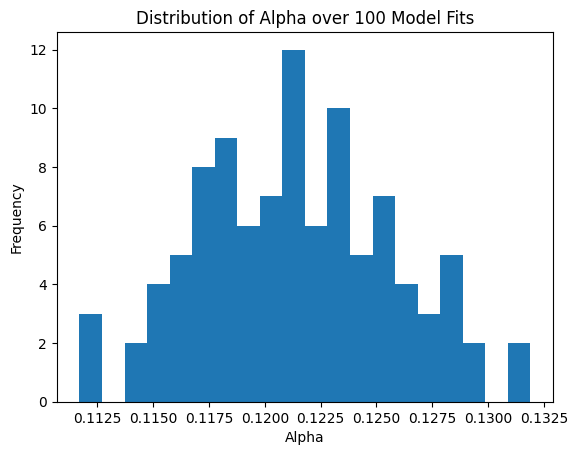

Mean alpha:   0.1214
Median alpha: 0.1213
Max alpha:    0.1319


In [33]:
# Rerun model 100 times
N = 100
alphas = []
for i in range(N):
    # fit the net with a new seed, silence the OLS summary
    _, _, ols = fitting_returns_data(
        'ff6_factors_19630701_20230131.csv',
        io_day_1_lag,
        model_feed_forward,
        seed=i,
        print_summary=False
    )
    alphas.append(ols.params['const'])

alphas = np.array(alphas)

# Plot histogram
plt.hist(alphas, bins=20)
plt.title("Distribution of Alpha over 100 Model Fits")
plt.xlabel("Alpha")
plt.ylabel("Frequency")
plt.show()

# Print summary statistics
print(f"Mean alpha:   {alphas.mean():.4f}")
print(f"Median alpha: {np.median(alphas):.4f}")
print(f"Max alpha:    {alphas.max():.4f}")